## Analyze A/B Test Results

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

### Importing needed libiraries

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

### Wrangling the data

In [2]:
# reading the data and storing it in a dataframe
df = pd.read_csv('Raw_Data/ab_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# number of rows in the dataset
df.shape[0]

294478

In [4]:
# the number of unique users in the dataset
len(df.user_id.unique())

290584

In [5]:
# the proportion of total users that converted regardless of page = coverted / total
df[df['converted'] == 1]['converted'].count() / df['converted'].count()

0.11965919355605512

In [6]:
# the number of times a user from the experiment group landed in the old page
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False]['user_id'].count()

3893

In [7]:
# checking for missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### note:
For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

In [8]:
# extracing the rows where each group dont't line up with their landing page
df1 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False]
df1.head()

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0


In [9]:
# removing the rows where each group dont't align with their landing page
df2 = df.drop(index=df1.index)
df2

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
# number of unique user_ids are in df2
len(df2.user_id.unique())

290584

In [12]:
# checking for duplicates
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
# removing one of the dulicates
df2.drop_duplicates('user_id', inplace=True)

<a id='probability'></a>
### Part I - Probability

In [14]:
# the probability of an individual converting regardless of the page they receive after cleaning the dataset
p_converted = df2[df2['converted'] == 1]['converted'].count() / df2['converted'].count()
p_converted

0.11959708724499628

In [15]:
# the probability of an individual converting given he landed in the control group
p_control_converted = df2[(df2['converted'] == 1) & (df2['group'] == 'control')]['converted'].count() / df2[df2['group'] == 'control']['group'].count()
p_control_converted

0.1203863045004612

In [16]:
# the probability of an individual converting given he landed in the experiment group
p_treat_converted = df2[(df2['converted'] == 1) & (df2['group'] == 'treatment')]['converted'].count() / df2[df2['group'] == 'treatment']['group'].count()
p_treat_converted

0.11880806551510564

In [17]:
#  the probability that an individual received the new page
p_newpage = df2[df2['landing_page'] == 'new_page']['landing_page'].count() / df2['landing_page'].count()
p_newpage

0.5000619442226688

In [18]:
# calculating the actual difference observed in the dataset
obs_diff = p_treat_converted - p_control_converted

**Probability Conclusion**

- from the probability that an individual received the new page =0.5 we see that both groups had the same sample size.
- "p_control_converted" = 0.1204 -- and -- "p_treatment_converted" = 0.1188
- The propapility that an individual from the control group converted is almost equal to the propapility that an individual from the treatment group converted.
- thats is not a sufficient evidence to say that the new treatment page leads to more conversions
- rather it even did less conversions.

<a id='ab_test'></a>
### Part II - A/B Test

we assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.

$$H_0: p_{new} - p_{old} <= 0$$


$$H_1: p_{new} - p_{old} > 0$$

where **$p_{old}$** and **$p_{new}$** are the converted rates for the old and new pages.

### note:
Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

### calcualting how long has the experiment been running for

In [19]:
from datetime import timedelta

In [20]:
# sorting the data by timestamp so we can track the experiment progress
df2.sort_values(by='timestamp', ascending=True, inplace=True)

In [21]:
df2['timestamp'].max() - df2['timestamp'].min()

Timedelta('21 days 23:59:49.081927')

### the experiment has been running for 3 weeks
as we don't know for how long we should run the experiment to get the results we need, we can avoid that by running the test multiple times on different time intervals, tracking results progress and making an assumption out of it.

### calculating the results after one week

In [22]:
week1_prior =  df2['timestamp'].min() + timedelta(weeks=1)

In [23]:
# extracting the data of the first week
week1_df = df2[df2['timestamp'] <= week1_prior]

In [24]:
week1_df

,user_id,timestamp,group,landing_page,converted
131228,922696,2017-01-02 13:42:05.378582,treatment,new_page,0
184884,781507,2017-01-02 13:42:15.234051,control,old_page,0
83878,737319,2017-01-02 13:42:21.786186,control,old_page,0
102717,818377,2017-01-02 13:42:26.640581,treatment,new_page,0
158789,725857,2017-01-02 13:42:27.851110,treatment,new_page,0
...,...,...,...,...,...
171876,933416,2017-01-09 13:41:16.908743,treatment,new_page,0
171200,701777,2017-01-09 13:41:31.452585,treatment,new_page,0
80645,881251,2017-01-09 13:41:36.327582,control,old_page,0
236217,744985,2017-01-09 13:41:46.526450,treatment,new_page,0


In [25]:
# the convert rate for 𝑝_𝑛𝑒𝑤 page and 𝑝_old page under the null
p_converted_week1 = week1_df[week1_df['converted'] == 1]['converted'].count() / week1_df['converted'].count()
p_converted_week1

0.11850161175172533

In [26]:
# the convert rate for 𝑝_𝑛𝑒𝑤 page and 𝑝_old page
p_control_w1 = week1_df[(week1_df['converted'] == 1) & (week1_df['group'] == 'control')]['converted'].count() / week1_df[week1_df['group'] == 'control']['group'].count()
p_treatment_w1 = week1_df[(week1_df['converted'] == 1) & (week1_df['group'] == 'treatment')]['converted'].count() / week1_df[week1_df['group'] == 'treatment']['group'].count()
p_control_w1, p_treatment_w1

(0.1193644316134494, 0.11764452206912909)

In [27]:
# calculating the actual difference observed in the one week dataset
obs_diff_week1 = p_treatment_w1 - p_control_w1
obs_diff_week1

-0.0017199095443203027

In [28]:
# the number of individuals in the treatment group
𝑛_𝑛𝑒𝑤_w1 = week1_df[week1_df['group'] == 'treatment'].shape[0]
n_new_w1

46377

In [29]:
# the number of individuals in the control group
n_old_w1 = week1_df[week1_df['group'] == 'control'].shape[0]
n_old_w1

46069

In [30]:
# Simulate 10,000 𝑛_𝑛𝑒𝑤 and 𝑛_old transactions with a convert rate of 𝑝_𝑛𝑒𝑤 and 𝑝_old under the null
p_diffs_week1 = []
for _ in range(10000):
    new_page_converted_w1 = np.random.choice([1, 0], size=n_new_w1, p=[p_converted_week1, 1-p_converted_week1])
    old_page_converted_w1 = np.random.choice([1, 0], size=n_old_w1, p=[p_converted_week1, 1-p_converted_week1])
    p_new_w1 = new_page_converted_w1.mean()
    p_old_w1 = old_page_converted_w1.mean()
    p_diffs_week1.append(p_new_w1 - p_old_w1)
    
p_diffs_week1 = np.array(p_diffs_week1)

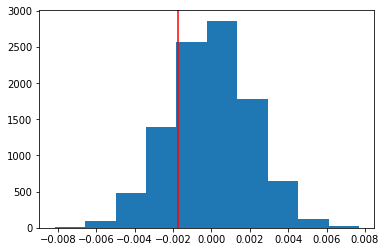

In [31]:
# Plotting a histogram of the p_diffs
plt.hist(p_diffs_week1);
plt.axvline(obs_diff_week1, c='red');

In [32]:
# calculating the P_value
# (the proportion of the p_diffs that are greater than the actual difference observed in the dateset)
(p_diffs_week1 > obs_diff_week1).mean()

0.7891

### calculating the results after two weeks

In [33]:
week2_prior =  df2['timestamp'].min() + timedelta(weeks=2)

In [34]:
week2_df = df2[df2['timestamp'] <= week2_prior]

In [35]:
week2_df

,user_id,timestamp,group,landing_page,converted
131228,922696,2017-01-02 13:42:05.378582,treatment,new_page,0
184884,781507,2017-01-02 13:42:15.234051,control,old_page,0
83878,737319,2017-01-02 13:42:21.786186,control,old_page,0
102717,818377,2017-01-02 13:42:26.640581,treatment,new_page,0
158789,725857,2017-01-02 13:42:27.851110,treatment,new_page,0
...,...,...,...,...,...
287237,643009,2017-01-16 13:41:48.089358,treatment,new_page,0
277357,711687,2017-01-16 13:41:57.235549,treatment,new_page,0
75739,925779,2017-01-16 13:41:58.527776,control,old_page,0
145943,906797,2017-01-16 13:42:02.541521,treatment,new_page,0


In [36]:
# the convert rate for 𝑝_𝑛𝑒𝑤 page and 𝑝_old page under the null
p_converted_week2 = week2_df[week2_df['converted'] == 1]['converted'].count() / week2_df['converted'].count()
p_converted_week2

0.1185993589223842

In [37]:
# the convert rate for 𝑝_𝑛𝑒𝑤 page and 𝑝_old page
p_control_w2 = week2_df[(week2_df['converted'] == 1) & (week2_df['group'] == 'control')]['converted'].count() / week2_df[week2_df['group'] == 'control']['group'].count()
p_treatment_w2 = week2_df[(week2_df['converted'] == 1) & (week2_df['group'] == 'treatment')]['converted'].count() / week2_df[week2_df['group'] == 'treatment']['group'].count()
p_control_w2, p_treatment_w2

(0.1194472399874471, 0.11775315362018317)

In [38]:
# calculating the actual difference observed in the two week dataset
obs_diff_week2 = p_treatment_w2 - p_control_w2
obs_diff_week2

-0.001694086367263939

In [39]:
# the number of individuals in the treatment group
𝑛_𝑛𝑒𝑤_w2 = week2_df[week2_df['group'] == 'treatment'].shape[0]
n_new_w2

92592

In [40]:
# the number of individuals in the control group
n_old_w2 = week2_df[week2_df['group'] == 'control'].shape[0]
n_old_w2

92409

In [41]:
# Simulate 10,000 𝑛_𝑛𝑒𝑤 and 𝑛_old transactions with a convert rate of 𝑝_𝑛𝑒𝑤 and 𝑝_old under the null
p_diffs_week2 = []
for _ in range(10000):
    new_page_converted_w2 = np.random.choice([1, 0], size=n_new_w2, p=[p_converted_week2, 1-p_converted_week2])
    old_page_converted_w2 = np.random.choice([1, 0], size=n_old_w2, p=[p_converted_week2, 1-p_converted_week2])
    p_new_w2 = new_page_converted_w2.mean()
    p_old_w2 = old_page_converted_w2.mean()
    p_diffs_week2.append(p_new_w2 - p_old_w2)
    
p_diffs_week2 = np.array(p_diffs_week2)

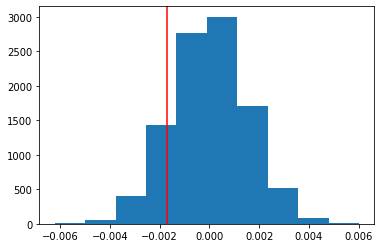

In [42]:
# Plotting a histogram of the p_diffs
plt.hist(p_diffs_week2);
plt.axvline(obs_diff_week2, c='red');

In [43]:
# calculating the P_value
# (the proportion of the p_diffs that are greater than the actual difference observed in the dateset)
(p_diffs_week2 > obs_diff_week2).mean()

0.8684

### calculating the results after the experiment has ended

In [44]:
# the convert rate for 𝑝_𝑛𝑒𝑤 page under the null
p_new = df2[df2['converted'] == 1]['converted'].count() / df2['converted'].count()
p_new

0.11959708724499628

In [45]:
# the convert rate for 𝑝_old page under the null
p_old = df2[df2['converted'] == 1]['converted'].count() / df2['converted'].count()
p_old

0.11959708724499628

In [46]:
# the number of individuals in the treatment group
𝑛_𝑛𝑒𝑤 = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

In [47]:
# the number of individuals in the control group
n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

In [48]:
# Simulating 𝑛_𝑛𝑒𝑤 transactions with a convert rate of 𝑝_𝑛𝑒𝑤 under the null
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, 1-p_new])
new_page_p = new_page_converted.mean()
new_page_p

0.11966141352969513

In [49]:
# Simulating 𝑛_old transactions with a convert rate of 𝑝_old under the null
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, 1-p_old])
old_page_p = old_page_converted.mean()
old_page_p

0.11760535264396933

In [50]:
# calculating the difference observed in the sample
p_new - p_old

0.0

In [51]:
# Simulate 10,000 𝑝_𝑛𝑒𝑤 - 𝑝_𝑜𝑙𝑑 values using the same process
p_diffs = []
for _ in range(10000):
    new_page_converted_1 = np.random.choice([1, 0], size=n_new, p=[p_new, 1-p_new])
    old_page_converted_1 = np.random.choice([1, 0], size=n_old, p=[p_old, 1-p_old])
    p_new_1 = new_page_converted_1.mean()
    p_old_1 = old_page_converted_1.mean()
    p_diffs.append(p_new_1 - p_old_1)
    
p_diffs = np.array(p_diffs)

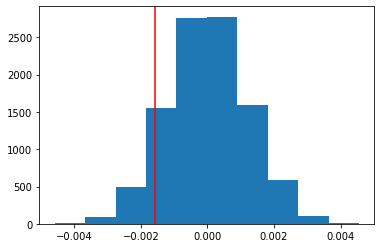

In [52]:
# Plotting a histogram of the p_diffs
plt.hist(p_diffs);
plt.axvline(obs_diff, c='red');

In [53]:
# calculating the P_value
# (the proportion of the p_diffs that are greater than the actual difference observed in the dateset)
(p_diffs > obs_diff).mean()

0.9085

**A/B Test Conclusion**

- after running the test after everyweek of the experiment we see that the p-value is getting larger and larger than the type I error rate of 5% which rejects the null hypothesis everytime.
- the last p-value is about 0.9 which is much larger than 5% which highly rejects the null hypothesis
- so the test result is that the new page is not better than the old page.

### note:
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

`n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [54]:
import statsmodels.api as sm

convert_old = df2[(df2['converted'] == 1) & (df2['group'] == 'control')]['converted'].count()
convert_new = df2[(df2['converted'] == 1) & (df2['group'] == 'treatment')]['converted'].count()
convert_old, convert_new, n_old ,n_new

(17489, 17264, 145274, 145310)

In [55]:
zscore, pval = sm.stats.proportions_ztest((convert_old, convert_new), (n_old, n_new), 0, 'smaller')
zscore, pval

(1.3109241984234394, 0.9050583127590245)

**Conclusion**

- the p_value is > 0.05 (Type I error rate of 5%) then this doesn't reject the null hypothesis
- the new page is not better than the old page
- it agrees with the findings in the previous calculations as both p_values are almost the same.